In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import torch, torchvision, torchattacks
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap
import data, hdc, sim, poison, JSMA, DeepFool, SparseFool, MMD1, MMD2
import cmath, copy

%matplotlib inline
import matplotlib.pyplot as plt

In [36]:
# Device settings
torch.manual_seed(1000)
device = "cpu"

In [37]:
batch_size = 128
num_epochs = 2
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x
    
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

train_data = datasets.MNIST(root='mnist_data', train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root='mnist_data', train=False, transform=transforms.ToTensor(), download=True)

hdc_train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data), shuffle=True)
hdc_test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=True)
        
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316031
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.223984
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.606540
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.131389
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.729420

Test set: Average loss: 0.0054, Accuracy: 8850/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.751895
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.640682
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.517443
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.540116
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.370910

Test set: Average loss: 0.0030, Accuracy: 9282/10000 (93%)



In [38]:
def check_adv_label (labels, images, adv_images):
    print(labels[0])
    print(model(images[0].unsqueeze(0)), model(images[0].unsqueeze(0)).max(1, keepdim=True)[1])
    print(model(adv_images[0].unsqueeze(0)), model(adv_images[0].unsqueeze(0)).max(1, keepdim=True)[1])

    count = 0    
    for img in adv_images:
        if model(img.unsqueeze(0)).max(1, keepdim=True)[1] != 4:
            count = count + 1
    
    print(count, (count*100)/128)

In [39]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(train_loader))
images, labels = batch

count = 0
lbl4data = []
for batch_idx, (data, target) in enumerate(train_loader):
    if count == 200:
        break
    for img, label in zip(data, target):
        if count == 200:
            break
        if label == 4:
            lbl4data.append([img, label])
            count = count + 1

lbl4_train_loader = torch.utils.data.DataLoader(lbl4data, shuffle=True, batch_size=batch_size)            
lbl4_batch = next(iter(lbl4_train_loader))
images4, labels4 = lbl4_batch

#background = images
#e = shap.DeepExplainer(model, background)

In [40]:
'''
hdc_model = hdc.HDC(784, 10000, 10, device)
train_acc = hdc_model.train(hdc_train_loader, device)
test_acc = hdc_model.test(hdc_test_loader, device)
print(test_acc)
hdc_train_vectors = hdc_model.train_vectors

hdc_dp_attack = {"is": False,
                 "percent": -1,
                 "args": {"scale_dot": 1,
                          "scale_norm": 10,
                          "labels": [label for label in range(10)],
                          "one_d_len": 784,
                          "hdc_proj_len": 10000,
                          "view": [1, 28, 28]}}

split_data = data.random_split(train_data, 0.006)[1]
print(len(split_data))
adv_images = poison.hdc_dp(hdc_dp_attack["args"], {4:6}, -1, (split_data, hdc_model.train_vectors, hdc_model.proj, hdc_model.proj_inv))
#adv_images = hdc_dp(split_data(train_data))
#print(check_adv_label(labels, images, adv_images))
'''

'\nhdc_model = hdc.HDC(784, 10000, 10, device)\ntrain_acc = hdc_model.train(hdc_train_loader, device)\ntest_acc = hdc_model.test(hdc_test_loader, device)\nprint(test_acc)\nhdc_train_vectors = hdc_model.train_vectors\n\nhdc_dp_attack = {"is": False,\n                 "percent": -1,\n                 "args": {"scale_dot": 1,\n                          "scale_norm": 10,\n                          "labels": [label for label in range(10)],\n                          "one_d_len": 784,\n                          "hdc_proj_len": 10000,\n                          "view": [1, 28, 28]}}\n\nsplit_data = data.random_split(train_data, 0.006)[1]\nprint(len(split_data))\nadv_images = poison.hdc_dp(hdc_dp_attack["args"], {4:6}, -1, (split_data, hdc_model.train_vectors, hdc_model.proj, hdc_model.proj_inv))\n#adv_images = hdc_dp(split_data(train_data))\n#print(check_adv_label(labels, images, adv_images))\n'

In [41]:
'''
print(len(adv_images), adv_images[0][0].shape)
plt.imshow(adv_images[120][0].numpy()[0])
print(model(adv_images[120][0].unsqueeze(0)).max(1, keepdim=True)[1])
'''

'\nprint(len(adv_images), adv_images[0][0].shape)\nplt.imshow(adv_images[120][0].numpy()[0])\nprint(model(adv_images[120][0].unsqueeze(0)).max(1, keepdim=True)[1])\n'

tensor(4)
tensor([[1.5702e-04, 2.3457e-04, 3.3204e-04, 6.4660e-04, 8.9798e-01, 6.4398e-03,
         3.7275e-03, 2.2394e-03, 4.2727e-03, 8.3973e-02]],
       grad_fn=<SoftmaxBackward>) tensor([[4]])
tensor([[3.1044e-04, 3.4350e-04, 5.0740e-04, 1.2960e-03, 8.3188e-01, 1.1830e-02,
         3.8846e-03, 4.9756e-03, 8.3855e-03, 1.3659e-01]],
       grad_fn=<SoftmaxBackward>) tensor([[4]])
13 10.15625
None


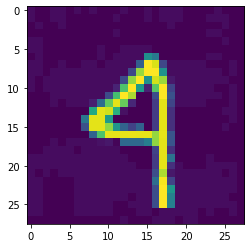

In [42]:
attack = torchattacks.FGSM(model, eps=8/255)
adv_images_FGSM = attack(images4, labels4)
print(check_adv_label(labels4, images4, adv_images_FGSM))
plt.imshow(adv_images_FGSM[120].numpy()[0])

tensor(4)
tensor([[1.5702e-04, 2.3457e-04, 3.3204e-04, 6.4660e-04, 8.9798e-01, 6.4398e-03,
         3.7275e-03, 2.2394e-03, 4.2727e-03, 8.3973e-02]],
       grad_fn=<SoftmaxBackward>) tensor([[4]])
tensor([[3.0707e-04, 3.3884e-04, 5.0073e-04, 1.2792e-03, 8.3262e-01, 1.1664e-02,
         3.8544e-03, 4.9391e-03, 8.2540e-03, 1.3624e-01]],
       grad_fn=<SoftmaxBackward>) tensor([[4]])
13 10.15625
None


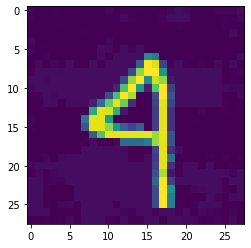

In [43]:
attack = torchattacks.PGD(model, eps=8/255, alpha=1/255, steps=10, random_start=True)
adv_images_PGD = attack(images4, labels4)
print(check_adv_label(labels4, images4, adv_images_PGD))
plt.imshow(adv_images_PGD[120].numpy()[0])

tensor(4)
tensor([[1.5702e-04, 2.3457e-04, 3.3204e-04, 6.4660e-04, 8.9798e-01, 6.4398e-03,
         3.7275e-03, 2.2394e-03, 4.2727e-03, 8.3973e-02]],
       grad_fn=<SoftmaxBackward>) tensor([[4]])
tensor([[1.5702e-04, 2.3457e-04, 3.3204e-04, 6.4660e-04, 8.9798e-01, 6.4398e-03,
         3.7275e-03, 2.2394e-03, 4.2727e-03, 8.3973e-02]],
       grad_fn=<SoftmaxBackward>) tensor([[4]])
10 7.8125
None


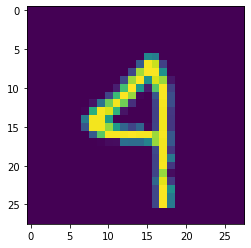

In [44]:
attack = torchattacks.CW(model, c=1, kappa=0, steps=50, lr=0.01)
adv_images_CW = attack(images4, labels4)
print(check_adv_label(labels4, images4, adv_images_CW))
plt.imshow(adv_images_CW[120].numpy()[0])

tensor(4)
tensor([[1.5702e-04, 2.3457e-04, 3.3204e-04, 6.4660e-04, 8.9798e-01, 6.4398e-03,
         3.7275e-03, 2.2394e-03, 4.2727e-03, 8.3973e-02]],
       grad_fn=<SoftmaxBackward>) tensor([[4]])
tensor([[3.3638e-04, 2.1538e-04, 4.7753e-04, 1.5060e-03, 7.8554e-01, 1.5010e-02,
         2.9557e-03, 5.9372e-03, 9.1672e-03, 1.7886e-01]],
       grad_fn=<SoftmaxBackward>) tensor([[4]])
20 15.625
None
CPU times: user 14min 12s, sys: 1.74 s, total: 14min 13s
Wall time: 15.3 s


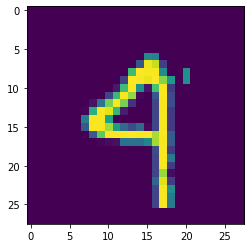

In [45]:
%%time
attack = JSMA.JSMA(model, theta=.5, gamma=0.01)
adv_images_JSMA = attack(images4, labels4)

print(check_adv_label(labels4, images4, adv_images_JSMA))
plt.imshow(adv_images_JSMA[120].numpy()[0])

In [46]:
%%time
attack = torchattacks.SPSA(model, eps=0.3)
adv_images_SPSA = attack(images4, labels4)

#print(check_adv_label(labels4, images4, adv_images_SPSA))
#plt.imshow(adv_images_SPSA[120].detach().numpy()[0])

CPU times: user 11.4 s, sys: 17.6 s, total: 28.9 s
Wall time: 837 ms


tensor(4)
tensor([[1.5702e-04, 2.3457e-04, 3.3204e-04, 6.4660e-04, 8.9798e-01, 6.4398e-03,
         3.7275e-03, 2.2394e-03, 4.2727e-03, 8.3973e-02]],
       grad_fn=<SoftmaxBackward>) tensor([[4]])
tensor([[4.7018e-03, 4.9634e-04, 1.3157e-03, 1.4543e-02, 1.6515e-01, 6.5939e-02,
         1.1720e-03, 1.4818e-01, 4.9153e-02, 5.4936e-01]],
       grad_fn=<SoftmaxBackward>) tensor([[9]])
104 81.25
None


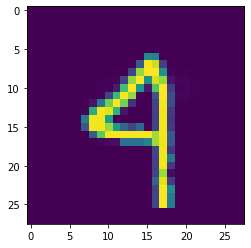

In [47]:
attack = DeepFool.DeepFool(model, steps=10, overshoot=0.02)
adv_images_DeepFool = attack(images4, labels4)
print(check_adv_label(labels4, images4, adv_images_DeepFool))
plt.imshow(adv_images_DeepFool[120].numpy()[0])

tensor(4)
tensor([[1.5702e-04, 2.3457e-04, 3.3204e-04, 6.4660e-04, 8.9798e-01, 6.4398e-03,
         3.7275e-03, 2.2394e-03, 4.2727e-03, 8.3973e-02]],
       grad_fn=<SoftmaxBackward>) tensor([[4]])
tensor([[2.4473e-03, 1.7862e-04, 9.9343e-04, 5.5112e-03, 3.1760e-01, 3.5395e-02,
         1.5326e-03, 5.8460e-02, 2.3239e-02, 5.5464e-01]],
       grad_fn=<SoftmaxBackward>) tensor([[9]])
110 85.9375
None


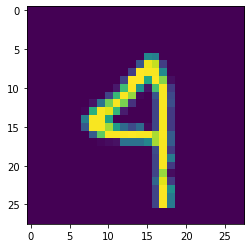

In [48]:
attack = SparseFool.SparseFool(model, steps=10, lam=1, overshoot=0.001)
adv_images_SparseFool = attack(images4, labels4)
print(check_adv_label(labels4, images4, adv_images_SparseFool))
plt.imshow(adv_images_SparseFool[120].numpy()[0])

divide by zero encountered in double_scalars


tensor(4)
tensor([[1.5702e-04, 2.3457e-04, 3.3204e-04, 6.4660e-04, 8.9798e-01, 6.4398e-03,
         3.7275e-03, 2.2394e-03, 4.2727e-03, 8.3973e-02]],
       grad_fn=<SoftmaxBackward>) tensor([[4]])
tensor([[1.9395e-04, 2.3956e-04, 3.7588e-04, 7.9441e-04, 8.7923e-01, 7.5855e-03,
         3.6288e-03, 2.9083e-03, 5.0872e-03, 9.9957e-02]],
       grad_fn=<SoftmaxBackward>) tensor([[4]])
8 6.25
None


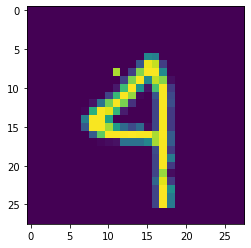

In [49]:
attack = torchattacks.OnePixel(model, pixels=1, steps=10, popsize=10, inf_batch=128)
adv_images_OnePixel = attack(images4, labels4)
print(check_adv_label(labels4, images4, adv_images_OnePixel))
plt.imshow(adv_images_OnePixel[120].numpy()[0])

tensor(4)
tensor([[1.5702e-04, 2.3457e-04, 3.3204e-04, 6.4660e-04, 8.9798e-01, 6.4398e-03,
         3.7275e-03, 2.2394e-03, 4.2727e-03, 8.3973e-02]],
       grad_fn=<SoftmaxBackward>) tensor([[4]])
tensor([[0.0060, 0.0031, 0.0059, 0.0230, 0.3064, 0.0662, 0.0065, 0.0897, 0.0756,
         0.4175]], grad_fn=<SoftmaxBackward>) tensor([[9]])
128 100.0
None


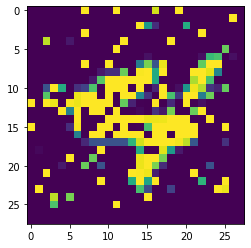

In [50]:
attack = torchattacks.Pixle(model, x_dimensions=(0.1, 0.2), restarts=10, max_iterations=50)
adv_images_Pixle = attack(images4, labels4)
print(check_adv_label(labels4, images4, adv_images_Pixle))
plt.imshow(adv_images_Pixle[0].numpy()[0])

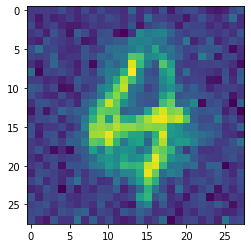

In [51]:
plt.imshow(adv_images_hdc[0][0][0])

In [52]:
%%time
attack = torchattacks.AutoAttack(model, norm='Linf', eps=8/255, version='standard', n_classes=10, seed=None, verbose=False)
adv_images_AutoAttack = attack(images4, labels4)
#print(check_adv_label(labels4, images4, adv_images_AutoAttack))
#plt.imshow(adv_images_AutoAttack[120].detach().numpy()[0])

CPU times: user 18min 23s, sys: 4.15 s, total: 18min 27s
Wall time: 20.3 s


In [53]:
import pickle
with open('hdc_adv_data.pickle', 'rb') as f:
    adv_images_hdc = pickle.load(f)
adv_images_hdc[0][0][0].shape

torch.Size([28, 28])

In [54]:
mmd21 = MMD2.MMD(adv_images_CW[0][0], adv_images_hdc[0][0][0])
mmd22 = MMD2.MMD(adv_images_PGD[0][0], adv_images_hdc[0][0][0])
mmd23 = MMD2.MMD(adv_images_FGSM[0][0], adv_images_hdc[0][0][0])
mmd24 = MMD2.MMD(adv_images_JSMA[0][0], adv_images_hdc[0][0][0])
mmd25 = MMD2.MMD(adv_images_DeepFool[0][0], adv_images_hdc[0][0][0])
mmd26 = MMD2.MMD(adv_images_SparseFool[0][0], adv_images_hdc[0][0][0])
print("From HDC", mmd21, mmd22, mmd23, mmd24, mmd25, mmd26)

mmd21 = MMD2.MMD(adv_images_hdc[0][0][0], adv_images_CW[0][0])
mmd22 = MMD2.MMD(adv_images_PGD[0][0], adv_images_CW[0][0])
mmd23 = MMD2.MMD(adv_images_FGSM[0][0], adv_images_CW[0][0])
mmd24 = MMD2.MMD(adv_images_JSMA[0][0], adv_images_CW[0][0])
mmd25 = MMD2.MMD(adv_images_DeepFool[0][0], adv_images_CW[0][0])
mmd26 = MMD2.MMD(adv_images_SparseFool[0][0], adv_images_CW[0][0])
print("From CW", mmd21, mmd22, mmd23, mmd24, mmd25, mmd26)

mmd21 = MMD2.MMD(adv_images_hdc[0][0][0], adv_images_PGD[0][0])
mmd22 = MMD2.MMD(adv_images_CW[0][0], adv_images_PGD[0][0])
mmd23 = MMD2.MMD(adv_images_FGSM[0][0], adv_images_PGD[0][0])
mmd24 = MMD2.MMD(adv_images_JSMA[0][0], adv_images_PGD[0][0])
mmd25 = MMD2.MMD(adv_images_DeepFool[0][0], adv_images_PGD[0][0])
mmd26 = MMD2.MMD(adv_images_SparseFool[0][0], adv_images_PGD[0][0])
print("From PGD", mmd21, mmd22, mmd23, mmd24, mmd25, mmd26)

mmd21 = MMD2.MMD(adv_images_hdc[0][0][0], adv_images_FGSM[0][0])
mmd22 = MMD2.MMD(adv_images_CW[0][0], adv_images_FGSM[0][0])
mmd23 = MMD2.MMD(adv_images_PGD[0][0], adv_images_FGSM[0][0])
mmd24 = MMD2.MMD(adv_images_JSMA[0][0], adv_images_FGSM[0][0])
mmd25 = MMD2.MMD(adv_images_DeepFool[0][0], adv_images_FGSM[0][0])
mmd26 = MMD2.MMD(adv_images_SparseFool[0][0], adv_images_FGSM[0][0])
print("From FGSM", mmd21, mmd22, mmd23, mmd24, mmd25, mmd26)

mmd21 = MMD2.MMD(adv_images_hdc[0][0][0], adv_images_JSMA[0][0])
mmd22 = MMD2.MMD(adv_images_CW[0][0], adv_images_JSMA[0][0])
mmd23 = MMD2.MMD(adv_images_PGD[0][0], adv_images_JSMA[0][0])
mmd24 = MMD2.MMD(adv_images_FGSM[0][0], adv_images_JSMA[0][0])
mmd25 = MMD2.MMD(adv_images_DeepFool[0][0], adv_images_JSMA[0][0])
mmd26 = MMD2.MMD(adv_images_SparseFool[0][0], adv_images_JSMA[0][0])
print("From JSMA", mmd21, mmd22, mmd23, mmd24, mmd25, mmd26)

mmd21 = MMD2.MMD(adv_images_hdc[0][0][0], adv_images_DeepFool[0][0])
mmd22 = MMD2.MMD(adv_images_CW[0][0], adv_images_DeepFool[0][0])
mmd23 = MMD2.MMD(adv_images_PGD[0][0], adv_images_DeepFool[0][0])
mmd24 = MMD2.MMD(adv_images_FGSM[0][0], adv_images_DeepFool[0][0])
mmd25 = MMD2.MMD(adv_images_JSMA[0][0], adv_images_DeepFool[0][0])
mmd26 = MMD2.MMD(adv_images_SparseFool[0][0], adv_images_DeepFool[0][0])
print("From DeepFool", mmd21, mmd22, mmd23, mmd24, mmd25, mmd26)

mmd21 = MMD2.MMD(adv_images_hdc[0][0][0], adv_images_SparseFool[0][0])
mmd22 = MMD2.MMD(adv_images_CW[0][0], adv_images_SparseFool[0][0])
mmd23 = MMD2.MMD(adv_images_PGD[0][0], adv_images_SparseFool[0][0])
mmd24 = MMD2.MMD(adv_images_FGSM[0][0], adv_images_SparseFool[0][0])
mmd25 = MMD2.MMD(adv_images_JSMA[0][0], adv_images_SparseFool[0][0])
mmd26 = MMD2.MMD(adv_images_DeepFool[0][0], adv_images_SparseFool[0][0])
print("From SparseFool", mmd21, mmd22, mmd23, mmd24, mmd25, mmd26)

From HDC tensor(0.0908) tensor(0.0929) tensor(0.0938) tensor(0.0922) tensor(0.0784) tensor(0.0870)
From CW tensor(0.0908) tensor(0.0011) tensor(0.0012) tensor(0.0008) tensor(0.0039) tensor(0.0068)
From PGD tensor(0.0929) tensor(0.0011) tensor(5.0026e-05) tensor(0.0017) tensor(0.0031) tensor(0.0076)
From FGSM tensor(0.0938) tensor(0.0012) tensor(5.0026e-05) tensor(0.0018) tensor(0.0031) tensor(0.0077)
From JSMA tensor(0.0922) tensor(0.0008) tensor(0.0017) tensor(0.0018) tensor(0.0030) tensor(0.0042)
From DeepFool tensor(0.0784) tensor(0.0039) tensor(0.0031) tensor(0.0031) tensor(0.0030) tensor(0.0057)
From SparseFool tensor(0.0870) tensor(0.0068) tensor(0.0076) tensor(0.0077) tensor(0.0042) tensor(0.0057)


In [60]:
def cal_MMD_dist():
    mmd_dist = 0
    for i in range(128):
        mmd_dist = mmd_dist + MMD2.MMD(adv_images_AutoAttack[i][0], adv_images_hdc[i][0][0])
    return mmd_dist/128

mmd21 = MMD2.MMD(adv_images_AutoAttack[0][0], adv_images_hdc[0][0][0])
mmd21 = cal_MMD_dist()
mmd22 = MMD2.MMD(adv_images_JSMA[0][0], adv_images_hdc[0][0][0])
mmd23 = MMD2.MMD(adv_images_PGD[0][0], adv_images_hdc[0][0][0])
mmd24 = MMD2.MMD(adv_images_FGSM[0][0], adv_images_hdc[0][0][0])
mmd25 = MMD2.MMD(adv_images_CW[0][0], adv_images_hdc[0][0][0])
mmd26 = MMD2.MMD(adv_images_SPSA[0][0], adv_images_hdc[0][0][0])
print("From FGSM", mmd21, mmd22, mmd23, mmd24, mmd25, mmd26)

From FGSM tensor(0.0908, grad_fn=<MeanBackward0>) tensor(0.0869, grad_fn=<DivBackward0>) tensor(0.0922) tensor(0.0929) tensor(0.0938) tensor(0.0908) tensor(0.0919, grad_fn=<MeanBackward0>)


In [56]:
import dcor
random_state = np.random.default_rng(63263)

def ED(x, y):
    return dcor.homogeneity.energy_test(x, y, num_resamples=200, random_state=random_state)

print (ED(adv_images_hdc[0][0][0], adv_images_SparseFool[0][0]))
print (ED(adv_images_AutoAttack[0][0].detach().numpy(), adv_images_FGSM[0][0]))
print (ED(adv_images_JSMA[0][0], adv_images_FGSM[0][0]))
print (ED(adv_images_PGD[0][0], adv_images_FGSM[0][0]))
print (ED(adv_images_CW[0][0], adv_images_FGSM[0][0]))
print (ED(adv_images_SPSA[0][0].detach().numpy(), adv_images_FGSM[0][0]))

HypothesisTest(pvalue=0.009950248756218905, statistic=5.5746433596467515)
HypothesisTest(pvalue=1.0, statistic=0.31766666671046195)
HypothesisTest(pvalue=1.0, statistic=0.3752591693838747)
HypothesisTest(pvalue=1.0, statistic=0.059932626746417306)
HypothesisTest(pvalue=1.0, statistic=0.31766666671046195)
HypothesisTest(pvalue=1.0, statistic=0.20169785631231818)


In [24]:
def abc_conf_metric(img, target):
    score = 0
        
    shap_values = e.shap_values(img)
    
    for s_img in shap_values:
        t_img = img
        changed_attrs = 0
        for p, batch in enumerate(s_img):
            for q, channel in enumerate(batch):
                for r, row in enumerate(channel):
                    for s, col in enumerate(row):
                        if s_img[p][q][r][s] > 0.001:
                            changed_attrs = changed_attrs + 1
                            t_img[p][q][r][s] = img[p][q][r][s] + 2
                            
        print ("No of high valued features attributions", changed_attrs)
        
        # Test for the mutated images
        mutated_label = test_image(t_img)[0]
        print("Mutated Label", mutated_label)
        # Does the mutated image is classified correctly?
        if target == mutated_label:
            score += 1
        
    return score/10